In [1]:
import sqlite3
import pandas as pd
import os
import json
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re
import pickle

/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# Connect to database
conn = sqlite3.connect("../../../databases/MLB_Betting.db")

In [3]:
import os

os.chdir('/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment')


/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment/training
/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment



# CREATING PANDAS DF FOR FEATURES

In [4]:
# NEW WAY:

from utils.featureExtraction import buildFeatures

# Step 1: Load data from SQL
join_query = """
SELECT 
    Features.game_id,
    OldGames.season,
    Features.features_json
FROM 
    Features
INNER JOIN 
    OldGames ON Features.game_id = OldGames.game_id
"""
df = pd.read_sql_query(join_query, conn)

# Step 2: Parse features JSON
df["features_json"] = df["features_json"].apply(json.loads)
df["season"] = df["season"].astype(int)

# Step 3: Extract features using the utility function
X_all, y_all, feature_names = buildFeatures(df, method="raw")  


print(X_all.shape)
print(y_all.shape)
print(feature_names)
print(len(feature_names))

# Step 4: Add game_id and season back to X_all if needed
X_all = pd.concat([df[["game_id", "season"]], X_all], axis=1)
X_all["label"] = y_all

print(X_all.shape)

# Step 5: Split into train/test sets
df_train = X_all[X_all["season"] <= 2022]
df_test = X_all[X_all["season"] >= 2023]

# get the train and test sets for features and targets
X_train = df_train[feature_names]
X_test = df_test[feature_names]

Y_train = df_train["label"]
Y_test = df_test["label"]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

game_ids_train = df_train["game_id"]
game_ids_test = df_test["game_id"]

21972
(21972, 64)
(21972,)
['season_home_avg_runs_scored', 'season_home_avg_batting_avg', 'season_home_avg_obp', 'season_home_avg_slg', 'season_home_avg_batting_k_pct', 'season_home_avg_bb_pct', 'season_home_avg_babip', 'season_home_avg_runs_given', 'season_home_avg_era', 'season_home_avg_whip', 'season_home_avg_opponent_obp', 'season_home_avg_opponent_slg', 'season_home_avg_k_per_9', 'season_home_avg_pitching_k_pct', 'season_home_avg_bb_per_9', 'season_home_avg_hr_per_9', 'rolling_home_avg_runs_scored', 'rolling_home_avg_batting_avg', 'rolling_home_avg_obp', 'rolling_home_avg_slg', 'rolling_home_avg_batting_k_pct', 'rolling_home_avg_bb_pct', 'rolling_home_avg_babip', 'rolling_home_avg_runs_given', 'rolling_home_avg_era', 'rolling_home_avg_whip', 'rolling_home_avg_opponent_obp', 'rolling_home_avg_opponent_slg', 'rolling_home_avg_k_per_9', 'rolling_home_avg_pitching_k_pct', 'rolling_home_avg_bb_per_9', 'rolling_home_avg_hr_per_9', 'season_away_avg_runs_scored', 'season_away_avg_batting_

# LOGISTIC REGRESSION

season_home_avg_runs_scored: 0.0493
season_home_avg_batting_avg: 0.3728
season_home_avg_obp: 0.0664
season_home_avg_slg: -0.1089
season_home_avg_batting_k_pct: 0.1604
season_home_avg_bb_pct: 0.0538
season_home_avg_babip: -0.3052
season_home_avg_runs_given: -0.1531
season_home_avg_era: 0.0935
season_home_avg_whip: -0.1399
season_home_avg_opponent_obp: 0.0666
season_home_avg_opponent_slg: 0.0207
season_home_avg_k_per_9: 0.0573
season_home_avg_pitching_k_pct: -0.0252
season_home_avg_bb_per_9: 0.0318
season_home_avg_hr_per_9: -0.0562
rolling_home_avg_runs_scored: 0.0085
rolling_home_avg_batting_avg: -0.1691
rolling_home_avg_obp: 0.0341
rolling_home_avg_slg: 0.0649
rolling_home_avg_batting_k_pct: 0.0023
rolling_home_avg_bb_pct: -0.0496
rolling_home_avg_babip: 0.0970
rolling_home_avg_runs_given: 0.0200
rolling_home_avg_era: -0.0452
rolling_home_avg_whip: -0.1073
rolling_home_avg_opponent_obp: 0.1502
rolling_home_avg_opponent_slg: -0.0521
rolling_home_avg_k_per_9: 0.1173
rolling_home_avg_pitc

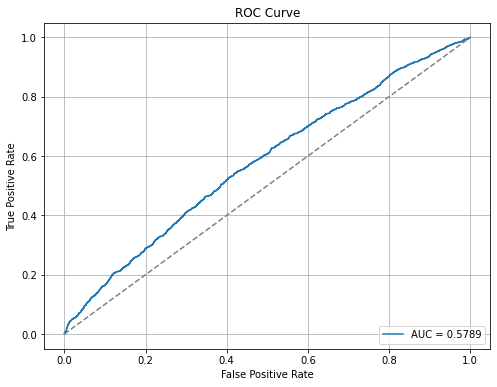

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler

# Scale for logistic regression because sensitive to scale

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Initialize logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42) 
# Train the model
logreg.fit(X_train_scaled, Y_train)

for feature, weight in zip(X_train.columns, logreg.coef_[0]):
    print(f"{feature}: {weight:.4f}")

print(logreg.intercept_)

# exporting the model weights + features + scaler

with open('training/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(logreg, f)

with open('training/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
with open('training/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# Predict on test set
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]  

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [6]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

ModuleNotFoundError: No module named 'shap'

# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt


# set scale_pos_weight for class imbalance
neg, pos = np.bincount(Y_train)
scale_pos_weight = neg / pos

# 2. Define parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'reg_alpha': [0, 0.5, 1.0],
    'reg_lambda': [1.0, 2.0]
}

# 3. Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# 4. Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Grid Search
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# 6. Fit and get best model
grid_search.fit(X_train, Y_train)
best_model = grid_search.best_estimator_

In [ ]:

print(best_model)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# MLP

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

mlp = MLPClassifier(max_iter=200)

# Define the hyperparameter grid you want to search over
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],  # L2 penalty (regularization term)
    'learning_rate': ['constant', 'adaptive']
}

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1, verbose=2)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Fit to your training data
grid_search.fit(X_train_scaled, Y_train)

# Best params & best estimator
print("Best params:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]  

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core

KeyboardInterrupt: 

# Train all Models


Logistic Regression:
Accuracy: 0.5602
Precision: 0.5637
Recall: 0.7124
F1 Score: 0.6294

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.39      0.46      2237
           1       0.56      0.71      0.63      2465

    accuracy                           0.56      4702
   macro avg       0.56      0.55      0.54      4702
weighted avg       0.56      0.56      0.55      4702

[0]	validation_0-logloss:0.68795
[1]	validation_0-logloss:0.68877
[2]	validation_0-logloss:0.68803
[3]	validation_0-logloss:0.68753
[4]	validation_0-logloss:0.68807
[5]	validation_0-logloss:0.68908
[6]	validation_0-logloss:0.69010
[7]	validation_0-logloss:0.68920
[8]	validation_0-logloss:0.69110
[9]	validation_0-logloss:0.69095
[10]	validation_0-logloss:0.69412
[11]	validation_0-logloss:0.69529
[12]	validation_0-logloss:0.69628
[13]	validation_0-logloss:0.69753
[14]	validation_0-logloss:0.69758
[15]	validation_0-logloss:0.69754
[16]	validation_0-logloss:

/scratch/gilbreth/stevenwh/envs/MyQG2/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)



TabNet:
Accuracy: 0.5553
Precision: 0.5611
Recall: 0.6970
F1 Score: 0.6217

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.40      0.46      2237
           1       0.56      0.70      0.62      2465

    accuracy                           0.56      4702
   macro avg       0.55      0.55      0.54      4702
weighted avg       0.55      0.56      0.55      4702



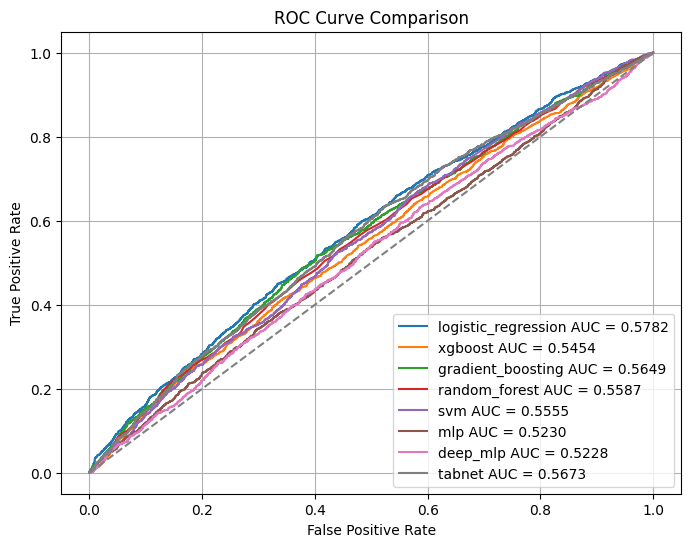


Model AUC Rankings:
logistic_regression: 0.5782
tabnet: 0.5673
gradient_boosting: 0.5649
random_forest: 0.5587
svm: 0.5555
xgboost: 0.5454
mlp: 0.5230
deep_mlp: 0.5228


In [3]:
import sqlite3
import json
import re
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    HAS_TABNET = True
except ImportError:
    HAS_TABNET = False
    print("Run pip install pytorch-tabnet")

feature_method = "raw"

os.chdir('/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment')
from utils.featureExtraction import buildFeatures

auc_scores = {}
roc_curves = {}

# Connect to database
conn = sqlite3.connect("../../databases/MLB_Betting.db")
join_query = """
SELECT 
    Features.game_id,
    OldGames.season,
    Features.features_json
FROM 
    Features
INNER JOIN 
    OldGames ON Features.game_id = OldGames.game_id
"""
df = pd.read_sql_query(join_query, conn)
df["features_json"] = df["features_json"].apply(json.loads)
df["season"] = df["season"].astype(int)

# Extract features
X_all, y_all, feature_names = buildFeatures(df, method=feature_method)
X_all = pd.concat([df[["game_id", "season"]], X_all], axis=1)
X_all["label"] = y_all

# Train/test split
df_train = X_all[X_all["season"] <= 2022]
df_test = X_all[X_all["season"] >= 2023]
X_train_full = df_train[feature_names]
Y_train_full = df_train["label"]
X_test = df_test[feature_names]
Y_test = df_test["label"]

# --- Validation Split for Early Stopping (10% of train data) ---
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_full, Y_train_full, test_size=0.1, random_state=42, stratify=Y_train_full
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

os.makedirs("training", exist_ok=True)
with open(f"training/model_files/scaler_{feature_method}.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open(f"training/model_files/feature_names_{feature_method}.pkl", "wb") as f:
    pickle.dump(feature_names, f)
with open(f"training/model_files/X_train_{feature_method}.pkl", "wb") as f:
    pickle.dump(X_train_full, f)
with open(f"training/model_files/X_test_{feature_method}.pkl", "wb") as f:
    pickle.dump(X_test, f)

def print_metrics(name, y_true, y_pred):
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

model_configs = {
    "logistic_regression": (LogisticRegression(max_iter=1000), True),
    "xgboost": (XGBClassifier(
        n_estimators=1000,
        early_stopping_rounds=25,
        eval_metric='logloss',
        random_state=42
    ), False),
    "gradient_boosting": (HistGradientBoostingClassifier(max_iter=500, random_state=42), True),
    "random_forest": (RandomForestClassifier(n_estimators=500, random_state=42), True),
    "svm": (SVC(kernel='rbf', probability=True), True)
}

for name, (model, use_scaling) in model_configs.items():
    if name == "xgboost":
        # Use early stopping on validation set
        model.fit(
            X_train if not use_scaling else X_train_scaled, Y_train,
            eval_set=[(X_val if not use_scaling else X_val_scaled, Y_val)],
            verbose=True
        )
        y_pred = model.predict(X_test if not use_scaling else X_test_scaled)
        y_proba = model.predict_proba(X_test if not use_scaling else X_test_scaled)[:, 1]
    else:
        model.fit(X_train_scaled if use_scaling else X_train, Y_train)
        y_pred = model.predict(X_test_scaled if use_scaling else X_test)
        y_proba = model.predict_proba(X_test_scaled if use_scaling else X_test)[:, 1]
    print_metrics(name.replace('_', ' ').title(), Y_test, y_pred)
    roc_auc = roc_auc_score(Y_test, y_proba)
    fpr, tpr, _ = roc_curve(Y_test, y_proba)
    roc_curves[name] = (fpr, tpr)
    auc_scores[name] = roc_auc
    with open(f"training/model_files/{name}_model_{feature_method}.pkl", "wb") as f:
        pickle.dump(model, f)

# --- MLP with Early Stopping ---
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 2)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

mlp_model = MLP(X_train_scaled.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.0005)
batch_size = 64
patience = 30
best_val_loss = float('inf')
counter = 0

train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(Y_train.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(Y_val.values, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(200):
    mlp_model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = mlp_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
    # Validation
    mlp_model.eval()
    with torch.no_grad():
        val_logits = mlp_model(torch.tensor(X_val_scaled, dtype=torch.float32))
        val_loss = criterion(val_logits, torch.tensor(Y_val.values, dtype=torch.long)).item()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = mlp_model.state_dict()
    else:
        counter += 1
    if counter >= patience:
        print(f"MLP Early stopping at epoch {epoch}")
        break

# Load best model and test
mlp_model.load_state_dict(best_model_state)
mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(torch.tensor(X_test_scaled, dtype=torch.float32))
    y_pred = logits.argmax(dim=1).numpy()
    y_proba = torch.softmax(logits, dim=1)[:, 1].numpy()
print_metrics("MLP", Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_proba)
fpr, tpr, _ = roc_curve(Y_test, y_proba)
roc_curves["mlp"] = (fpr, tpr)
auc_scores["mlp"] = roc_auc

torch.save(mlp_model.state_dict(), f"training/model_files/mlp_model_{feature_method}.pt")

# --- DeepMLP with Early Stopping ---
class DeepMLP(nn.Module):
    def __init__(self, input_size):
        super(DeepMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.model(x)

deep_mlp = DeepMLP(X_train_scaled.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_mlp.parameters(), lr=0.0005)
patience = 30
best_val_loss = float('inf')
counter = 0

train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(Y_train.values, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(Y_val.values, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(200):
    deep_mlp.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = deep_mlp(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
    # Validation
    deep_mlp.eval()
    with torch.no_grad():
        val_logits = deep_mlp(torch.tensor(X_val_scaled, dtype=torch.float32))
        val_loss = criterion(val_logits, torch.tensor(Y_val.values, dtype=torch.long)).item()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = deep_mlp.state_dict()
    else:
        counter += 1
    if counter >= patience:
        print(f"DeepMLP Early stopping at epoch {epoch}")
        break

# Load best model and test
deep_mlp.load_state_dict(best_model_state)
deep_mlp.eval()
with torch.no_grad():
    logits = deep_mlp(torch.tensor(X_test_scaled, dtype=torch.float32))
    y_pred = torch.argmax(logits, dim=1).numpy()
    y_proba = torch.softmax(logits, dim=1)[:, 1].numpy()
print_metrics("Deep MLP", Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_proba)
fpr, tpr, _ = roc_curve(Y_test, y_proba)
roc_curves["deep_mlp"] = (fpr, tpr)
auc_scores["deep_mlp"] = roc_auc

torch.save(deep_mlp.state_dict(), f"training/model_files/deep_mlp_model_{feature_method}.pt")

# --- TabNet
if HAS_TABNET:
    tabnet = TabNetClassifier(verbose=0)
    tabnet.fit(X_train_full.values, Y_train_full.values)
    y_pred = tabnet.predict(X_test.values)
    y_proba = tabnet.predict_proba(X_test.values)[:, 1]
    print_metrics("TabNet", Y_test, y_pred)
    roc_auc = roc_auc_score(Y_test, y_proba)
    fpr, tpr, _ = roc_curve(Y_test, y_proba)
    roc_curves["tabnet"] = (fpr, tpr)
    auc_scores["tabnet"] = roc_auc
    with open(f"training/model_files/tabnet_model_{feature_method}.pkl", "wb") as f:
        pickle.dump(tabnet, f)

# --- Plot all models
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} AUC = {auc_scores[model_name]:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- AUC Ranking
print("\nModel AUC Rankings:")
for model, score in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.4f}")


# Evaluating all Models

In [4]:
import sqlite3
import pandas as pd
import os
import json
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re
import pickle

os.chdir('/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment')
from evaluating.testOnCurrentSeason import main_evaluate

feature_method = "raw"

for model in ["logistic_regression", "gradient_boosting", "random_forest", "svm", "xgboost", "mlp", "deep_mlp", "tabnet"]:
    main_evaluate(model, feature_method)
    print(f"Finished {model}")

Finished logistic_regression
Finished gradient_boosting
Finished random_forest
Finished svm
Finished xgboost
Finished mlp
Finished deep_mlp
Finished tabnet


# Print Results

### Raw method

In [5]:
for model in ["logistic_regression", "gradient_boosting", "random_forest", "svm", "xgboost", "mlp", "deep_mlp", "tabnet"]:
    with open(f"evaluation_logs/testingOnCurrentSeason_{model}_raw.log", "r") as f:
        last_lines = f.readlines()[-9:]
        for line in last_lines:
            print(line.strip())
        print()


FINAL STATS
Model: logistic_regression
Feature Method: raw
Total Bets Placed: 862
Amount Wagered: 527.93 units
Skipped Games: 644
Total Profit: 10.58 units
Hit Rate: 48.72%
ROI: 2.00%

FINAL STATS
Model: gradient_boosting
Feature Method: raw
Total Bets Placed: 978
Amount Wagered: 666.95 units
Skipped Games: 528
Total Profit: -11.37 units
Hit Rate: 44.68%
ROI: -1.71%

FINAL STATS
Model: random_forest
Feature Method: raw
Total Bets Placed: 954
Amount Wagered: 627.30 units
Skipped Games: 552
Total Profit: -37.15 units
Hit Rate: 42.77%
ROI: -5.92%

FINAL STATS
Model: svm
Feature Method: raw
Total Bets Placed: 921
Amount Wagered: 568.34 units
Skipped Games: 585
Total Profit: -19.33 units
Hit Rate: 44.41%
ROI: -3.40%

FINAL STATS
Model: xgboost
Feature Method: raw
Total Bets Placed: 1000
Amount Wagered: 723.34 units
Skipped Games: 506
Total Profit: -14.32 units
Hit Rate: 44.1%
ROI: -1.98%

FINAL STATS
Model: mlp
Feature Method: raw
Total Bets Placed: 1238
Amount Wagered: 1819.13 units
Skippe

### Diff method

In [2]:
for model in ["logistic_regression", "gradient_boosting", "random_forest", "svm", "xgboost", "mlp", "deep_mlp", "tabnet"]:
    with open(f"evaluation_logs/testingOnCurrentSeason_{model}_diff.log", "r") as f:
        last_lines = f.readlines()[-9:]
        for line in last_lines:
            print(line.strip())
        print()


FINAL STATS
Model: logistic_regression
Feature Method: diff
Total Bets Placed: 852
Amount Wagered: 477.89 units
Skipped Games: 654
Total Profit: 1.35 units
Hit Rate: 47.42%
ROI: 0.28%

FINAL STATS
Model: gradient_boosting
Feature Method: diff
Total Bets Placed: 919
Amount Wagered: 616.11 units
Skipped Games: 587
Total Profit: -10.21 units
Hit Rate: 44.83%
ROI: -1.66%

FINAL STATS
Model: random_forest
Feature Method: diff
Total Bets Placed: 929
Amount Wagered: 627.32 units
Skipped Games: 577
Total Profit: -12.65 units
Hit Rate: 44.89%
ROI: -2.02%

FINAL STATS
Model: svm
Feature Method: diff
Total Bets Placed: 940
Amount Wagered: 557.92 units
Skipped Games: 566
Total Profit: -4.93 units
Hit Rate: 44.57%
ROI: -0.88%

FINAL STATS
Model: xgboost
Feature Method: diff
Total Bets Placed: 966
Amount Wagered: 580.13 units
Skipped Games: 540
Total Profit: 7.40 units
Hit Rate: 44.51%
ROI: 1.28%

FINAL STATS
Model: mlp
Feature Method: diff
Total Bets Placed: 1066
Amount Wagered: 1076.66 units
Skipp

In [6]:
!cat evaluation_logs/testingOnCurrentSeason_xgboost_diff.log

GAME INFO!, home team + odds + score comes first then away!
(778494, 'ATH', '+100', 4, 'CHC', '-118', 7)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.4587925 0.5412075]
home_probability = 0.541207492351532
away_probability = 0.458792507648468

UNIT SIZE RECOMMENDATION
teamToBetOn = home
unit_size = 0.412
expected_roi = 8.24

OUTCOME
Bet was wrong, lost 0.412 units
total running profit is -0.412


GAME INFO!, home team + odds + score comes first then away!
(778487, 'LAD', '-122', 3, 'ATL', '+104', 1)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.88611746 0.11388252]
home_probability = 0.11388251930475235
away_probability = 0.8861174583435059

UNIT SIZE RECOMMENDATION
teamToBetOn = away
unit_size = 3.883
expected_roi = 77.66

OUTCOME
Bet was wrong, lost 3.883 units
total running profit is -4.295


GAME INFO!, home team + odds + score comes first then away!
(778480, 'CIN', '-134', 0, 'TEX', '+116', 1)

MODEL PREDICTION PROBABILITIES, first is away, 2nd i

unit_size = 1.936
expected_roi = 38.71

OUTCOME
Bet was wrong, lost 1.936 units
total running profit is 71.54942174303062


GAME INFO!, home team + odds + score comes first then away!
(777355, 'SF', '-190', 5, 'MIA', '+160', 8)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.33727515 0.66272485]
home_probability = 0.6627248525619507
away_probability = 0.3372751474380493

UNIT SIZE RECOMMENDATION
teamToBetOn = home
unit_size = 0.11
expected_roi = 2.19

OUTCOME
Bet was wrong, lost 0.11 units
total running profit is 71.43942174303062


GAME INFO!, home team + odds + score comes first then away!
(777351, 'DET', '-158', 8, 'ATH', '+134', 0)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.27421784 0.72578216]
home_probability = 0.7257821559906006
away_probability = 0.2742178440093994

UNIT SIZE RECOMMENDATION
teamToBetOn = home
unit_size = 1.463
expected_roi = 29.25

OUTCOME
Bet was correct!
Profitted 0.9259493670886078 units
total running profit is 72.365371110

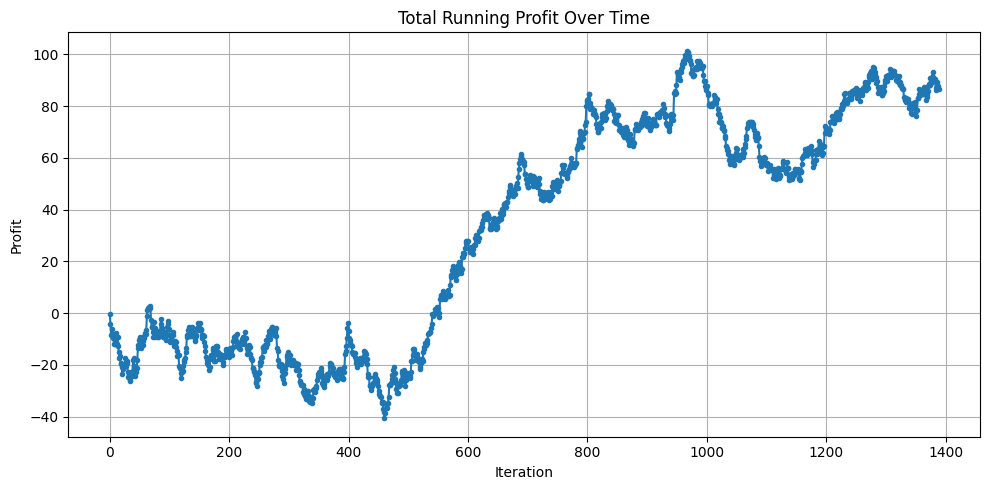

In [9]:
import re
import matplotlib.pyplot as plt

profit_values = []

with open("evaluation_logs/testingOnCurrentSeason_xgboost_diff.log", "r") as f:
    for line in f:
        match = re.search(r"total running profit is ([\-0-9.]+)", line)
        if match:
            profit = float(match.group(1))
            profit_values.append(profit)

plt.figure(figsize=(10, 5))
plt.plot(profit_values, marker='.')
plt.title("Total Running Profit Over Time")
plt.xlabel("Iteration")
plt.ylabel("Profit")
plt.grid(True)
plt.tight_layout()
plt.show()


# Gridsearch Best Features for XGBoost

In [1]:
import sqlite3
import json
import re
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

os.chdir('/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment')
from utils.featureExtraction import buildFeatures
from evaluating.testOnCurrentSeason import main_evaluate

# Settings
feature_method = "diff"  # or "raw"
model_base = "xgboost"
results_dir = "training/model_files"
eval_log_dir = "evaluation_logs"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(eval_log_dir, exist_ok=True)

# Load data from SQL
conn = sqlite3.connect("../../databases/MLB_Betting.db")
join_query = """
SELECT 
    Features.game_id,
    OldGames.season,
    Features.features_json
FROM 
    Features
INNER JOIN 
    OldGames ON Features.game_id = OldGames.game_id
"""
df = pd.read_sql_query(join_query, conn)
df["features_json"] = df["features_json"].apply(json.loads)
df["season"] = df["season"].astype(int)

# Extract features
X_all, y_all, feature_names = buildFeatures(df, method=feature_method)
X_all = pd.concat([df[["game_id", "season"]], X_all], axis=1)
X_all["label"] = y_all

# Train/test split
df_train = X_all[X_all["season"] <= 2022]
df_test = X_all[X_all["season"] >= 2023]

X_train = df_train[feature_names]
Y_train = df_train["label"]

# Standardize features for ranking (XGBoost itself doesn't need scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Feature ranking with RFE + XGBoost
xgb_ranker = XGBClassifier(eval_metric='logloss')
rfe = RFE(xgb_ranker, n_features_to_select=1, step=1)
rfe.fit(X_train_scaled, Y_train)

ranking_df = pd.DataFrame({
    "feature": feature_names,
    "ranking": rfe.ranking_
}).sort_values(by="ranking")

# Grid of n_features to test
n_features_grid = list(range(1, min(30, len(feature_names)) + 1, 1))

# Loop over n_features, retrain and evaluate
for n_features in n_features_grid:
    top_features = ranking_df.head(n_features)["feature"].tolist()
    X_top = df_train[top_features].values
    model = XGBClassifier(eval_metric='logloss')
    model.fit(X_top, Y_train)
    
    # Save model and features
    model_filename = f"{model_base}_model_{feature_method}_{n_features}features.pkl"
    features_filename = f"feature_names_{feature_method}_{n_features}features.pkl"
    with open(f"{results_dir}/{model_filename}", "wb") as f:
        pickle.dump(model, f)
    with open(f"{results_dir}/{features_filename}", "wb") as f:
        pickle.dump(top_features, f)
    print(f"Saved XGBoost model with top {n_features} features.")

    # Evaluate
    print(f"Evaluating XGBoost with top {n_features} features")
    model_name = f"{model_base}_{n_features}features"
    main_evaluate(model_name=model_name, feature_method=feature_method)
    log_path = f"{eval_log_dir}/testingOnCurrentSeason_{model_name}_{feature_method}.log"
    if os.path.exists(log_path):
        with open(log_path, "r") as f:
            last_lines = f.readlines()[-9:]
            for line in last_lines:
                print(line.strip())
            print()
    else:
        print(f"Log file {log_path} not found.\n")


Saved XGBoost model with top 1 features.
Evaluating XGBoost with top 1 features
FINAL STATS
Model: xgboost_1features
Feature Method: diff
Total Bets Placed: 1016
Amount Wagered: 863.77 units
Skipped Games: 490
Total Profit: 12.79 units
Hit Rate: 46.65%
ROI: 1.48%

Saved XGBoost model with top 2 features.
Evaluating XGBoost with top 2 features
FINAL STATS
Model: xgboost_2features
Feature Method: diff
Total Bets Placed: 1162
Amount Wagered: 1437.43 units
Skipped Games: 344
Total Profit: -8.52 units
Hit Rate: 49.31%
ROI: -0.59%

Saved XGBoost model with top 3 features.
Evaluating XGBoost with top 3 features
FINAL STATS
Model: xgboost_3features
Feature Method: diff
Total Bets Placed: 1182
Amount Wagered: 1444.82 units
Skipped Games: 324
Total Profit: 38.70 units
Hit Rate: 49.32%
ROI: 2.68%

Saved XGBoost model with top 4 features.
Evaluating XGBoost with top 4 features
FINAL STATS
Model: xgboost_4features
Feature Method: diff
Total Bets Placed: 1198
Amount Wagered: 1513.79 units
Skipped Ga

In [6]:
import sqlite3
import json
import pickle
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.calibration import CalibratedClassifierCV

os.chdir('/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment')
from utils.featureExtraction import buildFeatures
from evaluating.testOnCurrentSeason import main_evaluate

# Settings
feature_method = "diff"
model_base = "xgboost"
results_dir = "training/model_files"
eval_log_dir = "evaluation_logs"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(eval_log_dir, exist_ok=True)

# Load data from SQL
conn = sqlite3.connect("../../databases/MLB_Betting.db")
join_query = """
SELECT 
    Features.game_id,
    OldGames.season,
    Features.features_json
FROM 
    Features
INNER JOIN 
    OldGames ON Features.game_id = OldGames.game_id
"""
df = pd.read_sql_query(join_query, conn)
df["features_json"] = df["features_json"].apply(json.loads)
df["season"] = df["season"].astype(int)

# Extract features
X_all, y_all, feature_names = buildFeatures(df, method=feature_method)
X_all = pd.concat([df[["game_id", "season"]], X_all], axis=1)
X_all["label"] = y_all

# Split train/test
df_train = X_all[X_all["season"] <= 2022]
df_test = X_all[X_all["season"] >= 2023]
X_train = df_train[feature_names]
Y_train = df_train["label"]

# Use RFE on the train set for feature ranking
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
xgb_ranker = XGBClassifier(eval_metric='logloss')
rfe = RFE(xgb_ranker, n_features_to_select=1, step=1)
rfe.fit(X_train_scaled, Y_train)

ranking_df = pd.DataFrame({
    "feature": feature_names,
    "ranking": rfe.ranking_
}).sort_values(by="ranking")

# Grid of n_features to test
n_features_grid = list(range(1, min(30, len(feature_names)) + 1, 1))

for n_features in n_features_grid:
    top_features = ranking_df.head(n_features)["feature"].tolist()
    X_top = df_train[top_features].values
    y_top = Y_train.values

    # DON'T fit the base model first!
    xgb_model = XGBClassifier(eval_metric='logloss')
    calibrated_model = CalibratedClassifierCV(xgb_model, method='sigmoid', cv=5)
    calibrated_model.fit(X_top, y_top)

    # Save calibrated model and feature list
    model_filename = f"{model_base}_{feature_method}_{n_features}features.pkl"
    features_filename = f"feature_names_{feature_method}_{n_features}features.pkl"
    with open(f"{results_dir}/{model_filename}", "wb") as f:
        pickle.dump(calibrated_model, f)
    with open(f"{results_dir}/{features_filename}", "wb") as f:
        pickle.dump(top_features, f)
    print(f"Saved XGBoost calibrated model with top {n_features} features.")

    # Evaluate
    print(f"Evaluating XGBoost with top {n_features} features")
    model_name = f"{model_base}_{n_features}features"
    main_evaluate(model_name=model_name, feature_method=feature_method)
    log_path = f"{eval_log_dir}/testingOnCurrentSeason_{model_name}_{feature_method}.log"
    if os.path.exists(log_path):
        with open(log_path, "r") as f:
            last_lines = f.readlines()[-9:]
            for line in last_lines:
                print(line.strip())
            print()
    else:
        print(f"Log file {log_path} not found.\n")


Saved XGBoost calibrated model with top 1 features.
Evaluating XGBoost with top 1 features
FINAL STATS
Model: xgboost_1features
Feature Method: diff
Total Bets Placed: 1016
Amount Wagered: 863.77 units
Skipped Games: 490
Total Profit: 12.79 units
Hit Rate: 46.65%
ROI: 1.48%

Saved XGBoost calibrated model with top 2 features.
Evaluating XGBoost with top 2 features
FINAL STATS
Model: xgboost_2features
Feature Method: diff
Total Bets Placed: 1162
Amount Wagered: 1437.43 units
Skipped Games: 344
Total Profit: -8.52 units
Hit Rate: 49.31%
ROI: -0.59%

Saved XGBoost calibrated model with top 3 features.
Evaluating XGBoost with top 3 features
FINAL STATS
Model: xgboost_3features
Feature Method: diff
Total Bets Placed: 1182
Amount Wagered: 1444.82 units
Skipped Games: 324
Total Profit: 38.70 units
Hit Rate: 49.32%
ROI: 2.68%

Saved XGBoost calibrated model with top 4 features.
Evaluating XGBoost with top 4 features
FINAL STATS
Model: xgboost_4features
Feature Method: diff
Total Bets Placed: 1

FINAL STATS
Model: xgboost_30features
Feature Method: diff
Total Bets Placed: 1246
Amount Wagered: 1969.42 units
Skipped Games: 260
Total Profit: 47.81 units
Hit Rate: 52.09%
ROI: 2.43%



In [12]:
!cat evaluation_logs/testingOnCurrentSeason_xgboost_diff.log

GAME INFO!, home team + odds + score comes first then away!
(778494, 'ATH', '+100', 4, 'CHC', '-118', 7)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.4587925 0.5412075]
home_probability = 0.541207492351532
away_probability = 0.458792507648468

UNIT SIZE RECOMMENDATION
teamToBetOn = home
unit_size = 0.412
expected_roi = 8.24

OUTCOME
Bet was wrong, lost 0.412 units
total running profit is -0.412


GAME INFO!, home team + odds + score comes first then away!
(778487, 'LAD', '-122', 3, 'ATL', '+104', 1)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.88611746 0.11388252]
home_probability = 0.11388251930475235
away_probability = 0.8861174583435059

UNIT SIZE RECOMMENDATION
teamToBetOn = away
unit_size = 3.883
expected_roi = 77.66

OUTCOME
Bet was wrong, lost 3.883 units
total running profit is -4.295


GAME INFO!, home team + odds + score comes first then away!
(778480, 'CIN', '-134', 0, 'TEX', '+116', 1)

MODEL PREDICTION PROBABILITIES, first is away, 2nd i

(777361, 'MIL', '+106', 4, 'PIT', '-124', 2)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.2247811 0.7752189]
home_probability = 0.7752189040184021
away_probability = 0.2247810959815979

UNIT SIZE RECOMMENDATION
teamToBetOn = home
unit_size = 2.816
expected_roi = 56.32

OUTCOME
Bet was correct!
Profitted 2.98496 units
total running profit is 82.91075698465154


GAME INFO!, home team + odds + score comes first then away!
(777370, 'CHW', '+130', 7, 'AZ', '-154', 3)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.6735655  0.32643452]
home_probability = 0.32643452286720276
away_probability = 0.6735655069351196

UNIT SIZE RECOMMENDATION
teamToBetOn = away
unit_size = 0.854
expected_roi = 17.09

OUTCOME
Bet was wrong, lost 0.854 units
total running profit is 82.05675698465154


GAME INFO!, home team + odds + score comes first then away!
(777362, 'LAA', '-122', 5, 'BOS', '+104', 2)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.7099738  0.290026

In [13]:
!cat evaluation_logs/testingOnCurrentSeason_xgboost_23features_diff.log

GAME INFO!, home team + odds + score comes first then away!
(778494, 'ATH', '+100', 4, 'CHC', '-118', 7)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.7234632  0.27653682]
home_probability = 0.27653682231903076
away_probability = 0.7234631776809692

UNIT SIZE RECOMMENDATION
teamToBetOn = away
unit_size = 1.986
expected_roi = 39.71

OUTCOME
Bet was correct!
Profitted 1.6830508474576271 units
total running profit is 1.6830508474576271


GAME INFO!, home team + odds + score comes first then away!
(778487, 'LAD', '-122', 3, 'ATL', '+104', 1)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.7774635 0.2225365]
home_probability = 0.22253650426864624
away_probability = 0.7774634957313538

UNIT SIZE RECOMMENDATION
teamToBetOn = away
unit_size = 2.817
expected_roi = 56.35

OUTCOME
Bet was wrong, lost 2.817 units
total running profit is -1.133949152542373


GAME INFO!, home team + odds + score comes first then away!
(778480, 'CIN', '-134', 0, 'TEX', '+116', 1)

MODE

expected_roi = 11.84

OUTCOME
Bet was wrong, lost 0.592 units
total running profit is 122.1811381842555


GAME INFO!, home team + odds + score comes first then away!
(777362, 'LAA', '-122', 5, 'BOS', '+104', 2)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.48876363 0.51123637]
home_probability = 0.5112363696098328
away_probability = 0.48876363039016724

UNIT SIZE RECOMMENDATION
GAME INFO!, home team + odds + score comes first then away!
(777360, 'SD', '-146', 1, 'WAS', '+124', 0)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.25870502 0.741295  ]
home_probability = 0.7412949800491333
away_probability = 0.2587050199508667

UNIT SIZE RECOMMENDATION
teamToBetOn = home
unit_size = 1.818
expected_roi = 36.36

OUTCOME
Bet was correct!
Profitted 1.2452054794520548 units
total running profit is 123.42634366370756


GAME INFO!, home team + odds + score comes first then away!
(777365, 'BAL', '+120', 0, 'TEX', '-142', 7)

MODEL PREDICTION PROBABILITIES, first is a

# Gridsearch Best Features for MLP